In [64]:
import h5py
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.externals import joblib
import pickle
import argparse
import os

DATA_DIR = '/bigdata/shared/analysis/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Creating dataset...
DYJets
[  2.03886557e-05   2.33401552e-05   1.76532030e-05 ...,   4.74968630e-07
   4.67644270e-07   3.92666152e-07]
Mean = 2.55286204265e-06


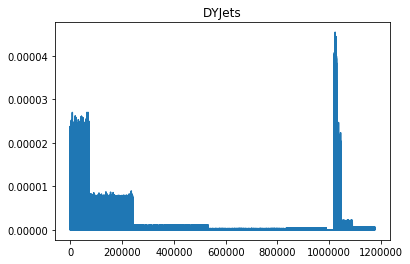

Other
[  6.31177681e-06   6.37398898e-06   7.05582033e-06 ...,   4.53069724e-08
   6.26283239e-08   3.15264148e-09]
Mean = 3.565050406e-07


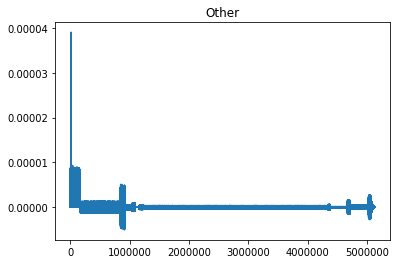

QCD
[  3.61866891e-01   3.58212233e-01   0.00000000e+00 ...,   4.49640766e-06
   4.34729009e-06   4.40470785e-06]
Mean = 0.000251380115515


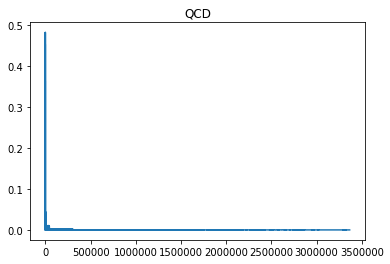

SingleTop
[  6.90841659e-07   5.31428157e-07   7.60240709e-07 ...,   5.33038110e-06
   6.95824565e-06   2.77108825e-06]
Mean = 1.69911402281e-06


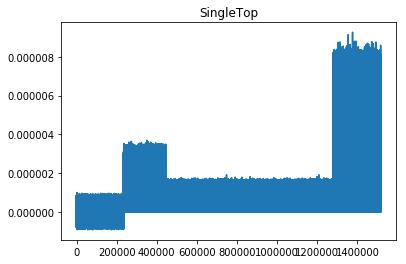

TTJets
[  1.12759582e-04   8.08404948e-05   8.47357369e-05 ...,   3.20330695e-09
   4.71096495e-09   9.40556188e-10]
Mean = 5.36941706741e-06


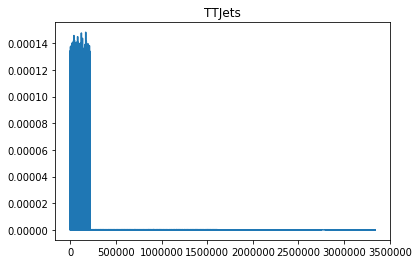

WJets
[  9.14879143e-04   9.31906688e-04   9.28493682e-04 ...,   5.88767364e-07
   5.88714329e-07   1.04452393e-08]
Mean = 6.17515024715e-06


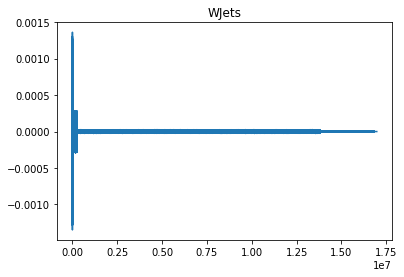

ZInv
[  1.69517643e-05   1.54114896e-05   1.96911951e-05 ...,   2.20262457e-08
   2.71238658e-08   2.07742401e-09]
Mean = 4.17173714595e-06


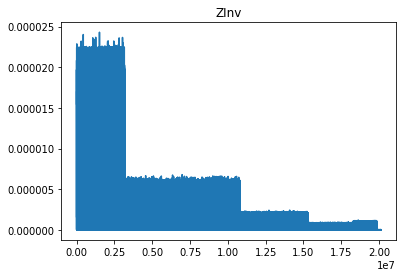

Signal
[  3.13006763e-06   3.09131519e-06   3.09771212e-06 ...,   2.82816382e-06
   2.99778276e-06   2.73681371e-06]
Mean = 3.0326527849e-06


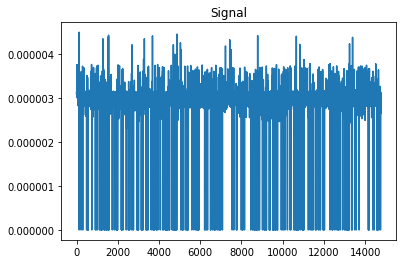

In [65]:
BACKGROUND = ['DYJets','Other','QCD','SingleTop','TTJets','WJets','ZInv']
SIGNAL = ['T2qq_900_850','T2qq_850_800','T2qq_800_750','T2qq_750_700','T2qq_700_650',
          'T2qq_650_600','T2qq_600_550','T2qq_550_500','T2qq_500_450', 'T2qq_450_400']

print ("Creating dataset...")
Mean = {}
for i,bkg in enumerate(BACKGROUND):
    _file = h5py.File(DATA_DIR+'/'+bkg+'.h5','r')
    Background = np.copy(_file['Data'])
    print bkg
    print Background['weight']
    print "Mean = {}".format(np.mean(Background['weight']))
    Mean[bkg] = np.mean(Background['weight'])
    plt.figure()
    plt.plot(Background['weight'])
    #plt.xscale('log')
    plt.title(bkg)
    plt.show()
    _file.close()
with h5py.File(DATA_DIR+'/'+SIGNAL[0]+'.h5','r') as sn:
    Signal = np.copy(sn['Data'])
    print "Signal"
    print Signal['weight']
    print "Mean = {}".format(np.mean(Signal['weight']))
    Mean['Signal'] = np.mean(Signal['weight'])
    plt.figure()
    plt.plot(Signal['weight'])
    #plt.xscale('log')
    plt.title('Signal')
    plt.show()

In [66]:
print Mean

{'ZInv': 4.1717371e-06, 'Signal': 3.0326528e-06, 'WJets': 6.1751502e-06, 'TTJets': 5.3694171e-06, 'Other': 3.5650504e-07, 'QCD': 0.00025138012, 'DYJets': 2.552862e-06, 'SingleTop': 1.699114e-06}


In [67]:
mean_weight = Mean.values()
scale_weight = mean_weight/max(mean_weight)
print scale_weight
Scale = {}
for i,sample in enumerate(Mean):
    Scale[sample] = 1.
    #Scale[sample] = scale_weight[i]
print Scale

[ 0.01659533  0.01206401  0.02456499  0.02135975  0.00141819  1.
  0.01015539  0.00675914]
{'ZInv': 1.0, 'Signal': 1.0, 'WJets': 1.0, 'TTJets': 1.0, 'Other': 1.0, 'QCD': 1.0, 'DYJets': 1.0, 'SingleTop': 1.0}


Resample dataset using undersampling method. 
1. Divide into training set, validation set, test set for both signal and background
2. For each set, undersample the background to be equal with signal


In [112]:
from training import to_regular_array

def split_dataset(dataset):
    np.random.shuffle(dataset)
    train_index = int(0.6 * dataset.shape[0])
    val_index = train_index*4/3
    training_set = dataset[:train_index]
    val_set = dataset[train_index:val_index]
    test_set = dataset[val_index:]
    return training_set, val_set, test_set

for i,bkg in enumerate(BACKGROUND):
    _file = h5py.File(DATA_DIR+'/'+bkg+'.h5','r')
    _background = to_regular_array(_file['Data'])
    if i == 0: Background = np.copy(_background)
    else: Background = np.vstack((Background, _background))
Signal = to_regular_array(h5py.File(DATA_DIR+SIGNAL[0]+'.h5','r')['Data'][:])

from training import clean_dataset
Signal = clean_dataset(Signal)
Background = clean_dataset(Background)
train_bkg, val_bkg, test_bkg = split_dataset(Background)
train_sn, val_sn, test_sn = split_dataset(Signal)

train_weight = float(train_sn.shape[0])/float(train_bkg.shape[0])
val_weight = float(val_sn.shape[0])/float(val_bkg.shape[0])

def random_frac(arr, fraction, label = ''):
    print("Getting a fraction of {} from {}".format(fraction,label))
    print("- Initial shape: ")
    print arr.shape
    sample_size = int(fraction*arr.shape[0])
    print("- Sampling {} entries".format(sample_size))
    idx = np.random.randint(arr.shape[0],size=sample_size)
    out = arr[idx,:]
    print("- Output shape: ")
    print out.shape
    return out

with h5py.File(DATA_DIR+"/Nosampling_Dataset.h5",'w') as outfile:
    print train_sn.shape
    print train_bkg.shape
    train_dataset = np.vstack((train_sn, train_bkg))
    val_dataset = np.vstack((val_sn, val_bkg))
    test_dataset = np.vstack((test_sn, test_bkg))
    print "Finished stacking"
    outfile.create_dataset("Training", data=train_dataset)
    outfile.create_dataset("Validation", data=val_dataset)
    outfile.create_dataset("Test",data=test_dataset)

train_bkg = random_frac(train_bkg, train_weight, "Training Background")
val_bkg = random_frac(val_bkg, train_weight, "Validation Background")

with h5py.File(DATA_DIR+"/Undersampling_Dataset.h5",'w') as outfile:
    print train_sn.shape
    print train_bkg.shape
    train_dataset = np.vstack((train_sn, train_bkg))
    val_dataset = np.vstack((val_sn, val_bkg))
    test_dataset = np.vstack((test_sn, test_bkg))
    print "Finished stacking"
    outfile.create_dataset("Training", data=train_dataset)
    outfile.create_dataset("Validation", data=val_dataset)
    outfile.create_dataset("Test",data=test_dataset)

Before cleaning: (14765, 16)
After cleaning: (14765, 16)
Before cleaning: (51627989, 16)
After cleaning: (51626328, 16)
(8859, 16)
(30975796, 16)
Finished stacking
Getting a fraction of 0.00028599749301 from Training Background
- Initial shape: 
(30975796, 16)
- Sampling 8859 entries
- Output shape: 
(8859, 16)
Getting a fraction of 0.00028599749301 from Validation Background
- Initial shape: 
(10325265, 16)
- Sampling 2952 entries
- Output shape: 
(2952, 16)
(8859, 16)
(8859, 16)
Finished stacking


For training and validation, need to have equal number of signal and background. For test set, keep the original to avoid repeated predictions.

In [77]:
def multiply_data(data, multiplicity):
    print ("Dataset size before multiplied by {}: {}".format(multiplicity,data.shape[0]))
    for i in range(multiplicity):
        if i==0: sum_data = np.copy(data)
        else: sum_data = np.vstack((sum_data, data))
    print ("Dataset size after multiplicity: {}".format(sum_data.shape[0]))
    return sum_data


Getting a fraction of 1.0 from train bkg
- Initial shape: 
(8859, 16)
- Sampling 8859 entries
- Output shape: 
(8859, 16)
Getting a fraction of 1.0 from val bkg
- Initial shape: 
(10325265, 16)
- Sampling 10325265 entries
- Output shape: 
(10325265, 16)
(8859, 16)
(8859, 16)


[u'Test', u'Training', u'Validation']
(10328220, 16)
(17718, 16)
[  0.00000000e+00   3.91568301e-06   2.97318041e-01   1.82533777e+00
   1.97240949e+00   1.52671997e+02   1.95736389e+02   8.76104236e-02
   1.22508293e+02   1.24914284e+02   1.14145149e+02   1.77636017e+02
   8.49363098e+01   2.00000000e+00   4.10554051e-01   3.01637039e+01]
1226.97410727


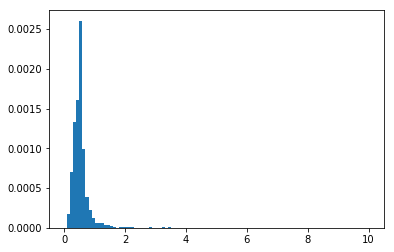

In [117]:
with h5py.File(DATA_DIR+"/Undersampling_Dataset.h5","r") as test:
    print(list(test.keys()))
    testset = test['Test'][:]
    print(testset.shape)
    print(trainset.shape)
    testbkg = testset[testset[:,0]<0.5]
    print(testbkg[0])
    testsn = testset[testset[:,0]>0.5]
    wsn = testsn[:,1]
    alphaTsn = testsn[:,2]
    snc, _, _ = plt.hist(alphaTsn, weights=wsn, bins=100, range=(0,10))
    print(sum(snc)*1000*35.9*0.8*5)

1234.63119707


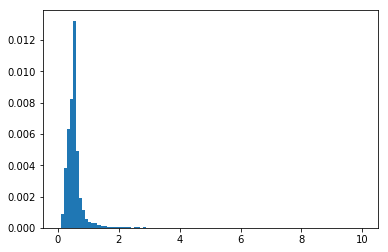

In [118]:
testsn = Signal[Signal[:,0]>0.5]
wsn = testsn[:,1]
alphaTsn = testsn[:,2]
snc, _, _ = plt.hist(alphaTsn, weights=wsn, bins=100, range=(0,10))
print(sum(snc)*1000*35.9*0.8)

(14765, 16)
1234.63119707


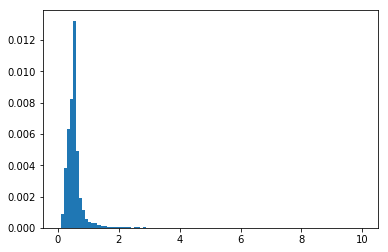

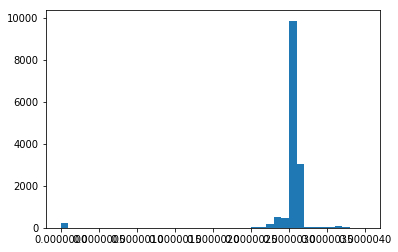

In [128]:
with h5py.File(DATA_DIR+'/'+SIGNAL[0]+'.h5','r') as sn:
    Signal = to_regular_array(sn['Data'])
    print Signal.shape
    testsn = Signal #[Signal[:,0]>0.5]
    wsn = testsn[:,1]
    alphaTsn = testsn[:,2]
    snc, _, _ = plt.hist(alphaTsn, weights=wsn, bins=100, range=(0,10))
    plt.figure()
    plt.hist(wsn,bins=40,range=(0,4e-6))
    print (sum(snc)*1000*35.9*0.8)